# Imports

In [2]:
import os
import ast
import spacy
import folium
import sqlite3
import squarify
import itertools
import webcolors
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from collections import Counter

# Settings base variables and paths

In [3]:
# Set the base folder path for the project
output_path = "../output"
images_path = os.path.join(output_path, "images")
metadata_path = os.path.join(output_path, "metadata")
config_path = os.path.join(output_path, "config")

list_of_paths = [output_path, images_path, metadata_path, config_path]

# Get the metadata from db and sort it with list into a dictionary

In [4]:
# Open a connection to the database
conn = sqlite3.connect(os.path.join(metadata_path, 'metadata.db'))
# Create a cursor
c = conn.cursor()
# Get a name of the first file in the images directory
metadata_file = os.listdir(images_path)
# Get the metadata of the first file

res = {}
for file in metadata_file :
    c.execute("SELECT * FROM metadata WHERE filename=?", (file,))
    # Print the metadata
    #Convert result to format: filename: [{key: value}...]
    metadata = c.fetchall()
    result = {}
    for row in metadata:
        if row[0] not in result:
            result[row[0]] = {}
        result[row[0]][row[1]] = row[2]
    res.update(result)

# créer des listes pour chaque prop
dict_metadata = {}

# liste toutes les propriétés des images
prop_list = []
for image in res:
    for prop in res[image]:
        if prop not in prop_list:
            prop_list.append(prop)

# ajout des props dans le dictionnaire
dict_metadata["file"] = []
for prop in prop_list:
    dict_metadata[prop] = []

# ajoute les valeurs des propriétés dans les listes
for image in res:
    dict_metadata["file"].append(image)
    for prop in prop_list:
        if prop in res[image]:
            dict_metadata[prop].append(res[image][prop])
        else:
            dict_metadata[prop].append(None)


for i in range(len(dict_metadata['Make'])):
    if dict_metadata['Make'][i] is not None:
        dict_metadata['Make'][i] = ''.join(filter(str.isalpha, dict_metadata['Make'][i])).replace('CORPORATION', '').replace('CORP', '').replace('COMPANY', '').replace('LTD', '').replace('IMAGING', '')

for i, key in enumerate(dict_metadata['DateTime']):
    if dict_metadata['DateTime'][i] is not None:
        dict_metadata['DateTime'][i] = dict_metadata['DateTime'][i].replace('T', ' ').replace('-', ':').split('+')[0]

# Close the connection
conn.close()

In [5]:
# compte les valeurs non null pour chaque propriété
# puis affiche les propriétés avec plus de 70 valeurs non nulles
prop_len = {}
for prop in dict_metadata:
    prop_len[prop] = len([x for x in dict_metadata[prop] if x is not None])
    if prop_len[prop] > 70:
        print(f'{prop} : {prop_len[prop]}')

file : 100
ResolutionUnit : 87
ExifOffset : 92
Make : 83
Model : 83
Software : 85
DateTime : 86
XResolution : 88
YResolution : 88
ExifVersion : 87
ShutterSpeedValue : 76
ApertureValue : 75
DateTimeOriginal : 85
DateTimeDigitized : 84
ExposureBiasValue : 81
MaxApertureValue : 71
MeteringMode : 82
CustomRendered : 79
Flash : 81
FocalLength : 82
ExposureMode : 82
WhiteBalance : 82
SceneCaptureType : 83
ExposureTime : 83
FNumber : 82
ExposureProgram : 80
ISOSpeedRatings : 83
tags : 100
dominant_color : 100
width : 96
height : 96
ColorSpace : 79


In [6]:
# affiche les 3 premiers éléments pour chaque liste
for prop in dict_metadata:
    if len(dict_metadata[prop]) > 70 and prop != "MakerNote":
        print(f'{prop} : {dict_metadata[prop][:3]}')


file : ['image_0.jpg', 'image_1.jpg', 'image_10.jpg']
ResolutionUnit : ['2', '2', '2']
ExifOffset : ['202', '246', '376']
Make : ['Canon', 'Panasonic', 'SONY']
Model : ['Canon EOS REBEL T3', 'DMC-GF1', 'SLT-A77V']
Software : ['Adobe Photoshop Lightroom 3.4', 'Adobe Photoshop Lightroom 5.6 (Macintosh)', 'SLT-A77V v1.07']
DateTime : ['2014:09:24 21:21:22', '2014:11:06 14:27:18', '2014:12:03 17:04:16']
XResolution : ['240.0', '240.0', '350.0']
YResolution : ['240.0', '240.0', '350.0']
ExifVersion : ["b'0230'", "b'0230'", "b'0230'"]
ShutterSpeedValue : ['6.643856', '7.643856', None]
ApertureValue : ['1.695994', '1.695994', None]
DateTimeOriginal : ['2014:09:24 20:09:26', '2013:12:07 12:17:20', '2014:12:03 17:04:16']
DateTimeDigitized : ['2014:09:24 20:09:26', '2013:12:07 12:17:20', '2014:12:03 17:04:16']
ExposureBiasValue : ['0.0', '0.0', '0.0']
MaxApertureValue : ['1.75', '1.53125', '4.96875']
MeteringMode : ['5', '5', '5']
CustomRendered : ['0', '0', '0']
Flash : ['16', '16', '16']
Focal

# Graph images : size

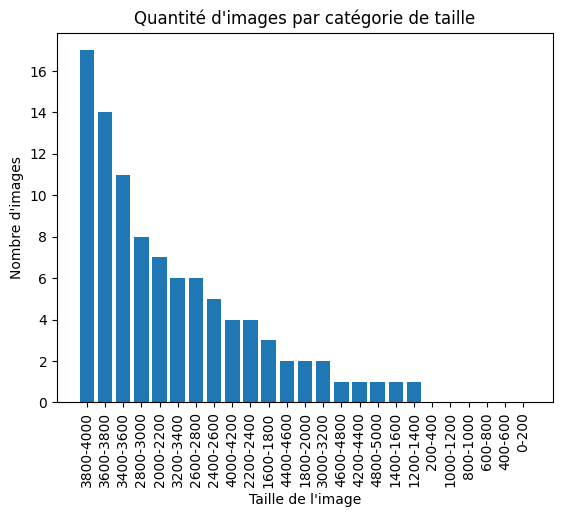

In [7]:
# interval des colonnes
bins_size = 200

# Convertir le dictionnaire en un DataFrame pandas
df = pd.DataFrame(dict_metadata)

# Créer une colonne pour la hauteur minimale
df['min_size'] = df[['width', 'height']].min(axis=1)

# Déterminer la hauteur minimale la plus grande
max_min_size = df['min_size'].max()

# Déterminer le nombre de bins nécessaires pour couvrir toutes les tailles d'image
num_bins = int(max_min_size / bins_size) + 1

# Définir les bins tous les 100 pixels
bins = [i * bins_size for i in range(num_bins + 1)]

# Définir les labels en utilisant des plages de pixels
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(num_bins)]

# Diviser la hauteur minimale en tranches de 100
df['size_category'] = pd.cut(df['min_size'], bins=bins, labels=labels)

# Compter le nombre d'images pour chaque catégorie de taille
size_counts = df['size_category'].value_counts()

# Créer un histogramme à barres en utilisant les données comptées
plt.bar(size_counts.index, size_counts.values)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()



In [8]:
# nb de colonnes
nb_colonnes = 7

# Convertir le dictionnaire en un DataFrame pandas
df = pd.DataFrame(dict_metadata)

# Créer une colonne pour la hauteur minimale
df['min_size'] = df[['height', 'width']].min(axis=1)

# Déterminer la hauteur minimale la plus grande
max_min_size = df['min_size'].max()

# Déterminer le nombre d'images
num_images = len(df)

# Déterminer le nombre de bins en fonction du nombre d'images et du nombre de colonnes souhaité
num_bins = int(num_images / (num_images / nb_colonnes))

# Définir les bins en utilisant le nombre de bins déterminé
bins = [i * (max_min_size / num_bins) for i in range(num_bins + 1)]

# Définir les labels en utilisant des plages de pixels
labels = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(num_bins)]

# Diviser la hauteur minimale en tranches de 100
df['size_category'] = pd.cut(df['min_size'], bins=bins, labels=labels)

# Compter le nombre d'images pour chaque catégorie de taille
size_counts = df['size_category'].value_counts()

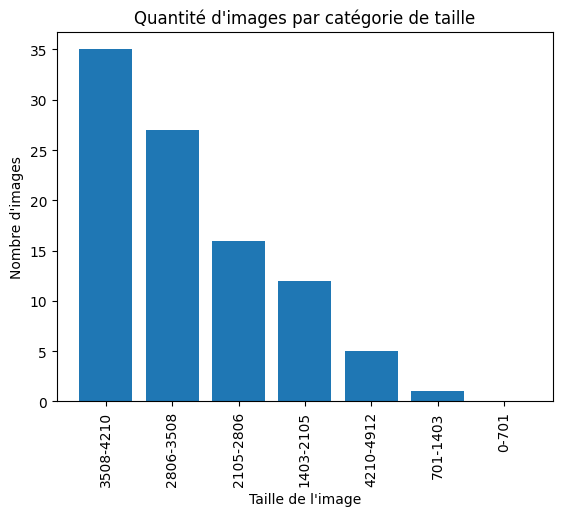

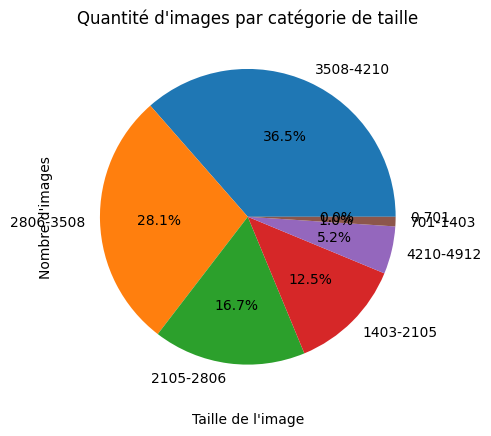

In [9]:
# Créer un histogramme à barres en utilisant les données comptées
plt.bar(size_counts.index, size_counts.values)
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.xticks(rotation=90)
plt.show()

plt.pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%')
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.show()


# Graph images : DateTime

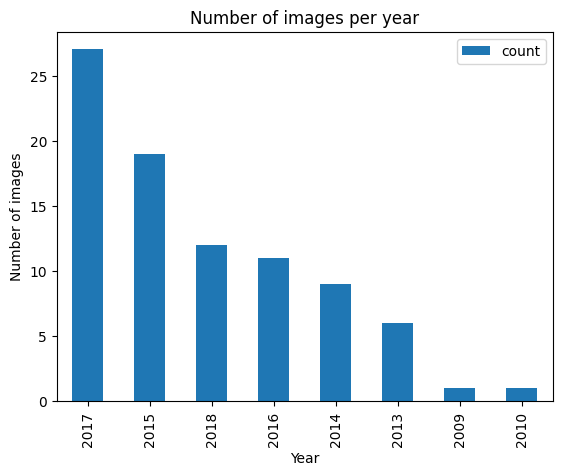

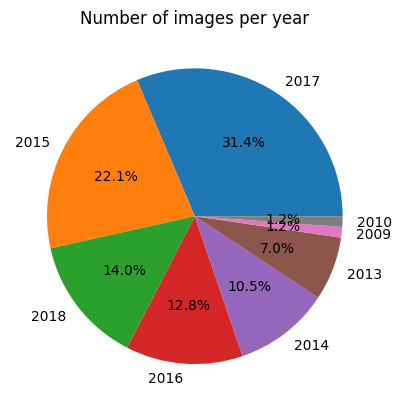

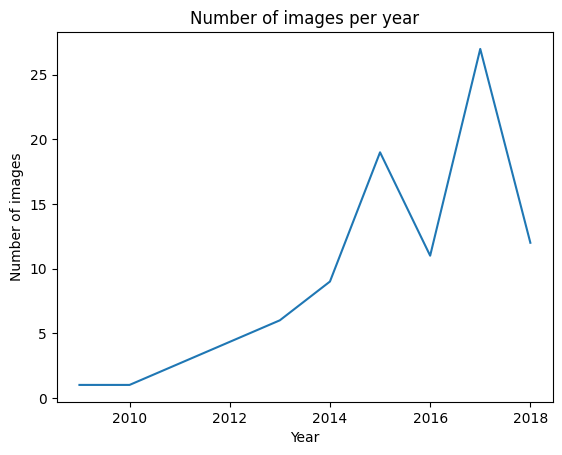

In [10]:
# Créer un DataFrame à partir du dictionnaire
df = pd.DataFrame(dict_metadata)

# Convertir les valeurs de DateTime en objets de type datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y:%m:%d %H:%M:%S')

# Ajouter une colonne pour l'année
df['Year'] = df['DateTime'].dt.year

# Grouper les images par année et compter le nombre d'images pour chaque année, puis trier les résultats par ordre décroissant de la valeur de la colonne 'Year'
image_count = df.groupby('Year').size().reset_index(name='count').sort_values('count', ascending=False)

# Convertir les années en entiers pour supprimer les décimales
image_count['Year'] = image_count['Year'].astype(int)

# Créer un graphique à barres pour visualiser le nombre d'images par année
image_count.plot(kind='bar', x='Year', y='count')
plt.xlabel('Year')
plt.ylabel('Number of images')
plt.title('Number of images per year')
plt.show()

plt.pie(image_count['count'], labels=image_count['Year'], autopct='%1.1f%%')
plt.title('Number of images per year')
plt.show()

# Grouper les images par année et compter le nombre d'images pour chaque année, puis trier les résultats par ordre croissant de la valeur de la colonne 'Year'
image_count = df.groupby('Year').size().reset_index(name='count').sort_values('Year', ascending=True)
plt.plot(image_count['Year'], image_count['count'])
plt.xlabel('Year')
plt.ylabel('Number of images')
plt.title('Number of images per year')
plt.show()


# Graph images : Make

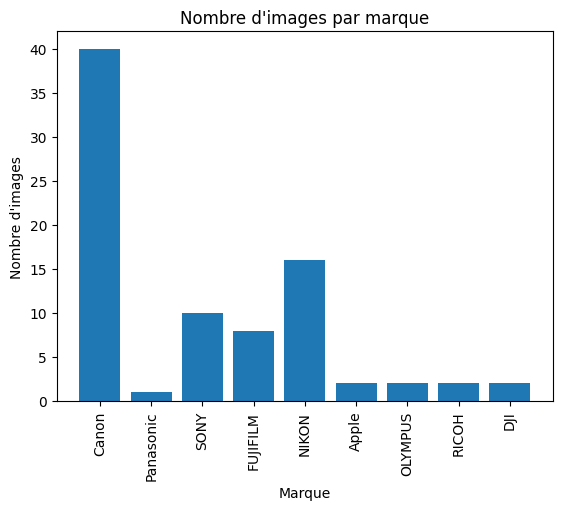

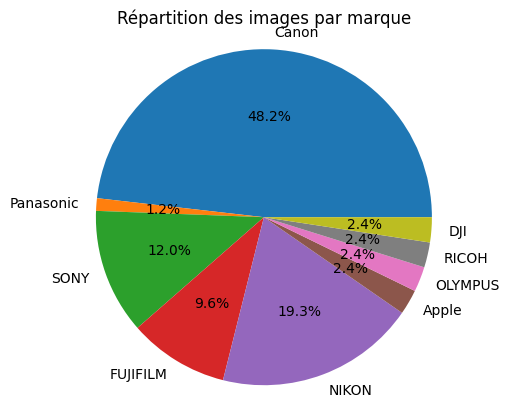

In [11]:
# initialiser un dictionnaire vide pour stocker le compte de chaque marque
counts = {}

# parcourir les valeurs de 'Make' et compter le nombre d'images associées à chaque marque
for make in dict_metadata['Make']:
    if make is not None:
        counts[make] = counts.get(make, 0) + 1

# convertir les résultats en listes pour la création du graphique
labels = list(counts.keys())
values = list(counts.values())

# créer le graphique en bâtons
plt.bar(labels, values)
plt.title('Nombre d\'images par marque')
plt.xlabel('Marque')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=90)
plt.show()


# Créer un graphique en camembert
labels = counts.keys()
sizes = counts.values()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Répartition des images par marque')
plt.show()

# Graph images : Images with GPS

In [12]:
# get images with GPS data and print it name and the GPS data
for idx, meta in enumerate(dict_metadata['GPSInfo']):
    if meta is not None and len(meta) > 24:
        print(dict_metadata['file'][idx])
        print(meta)

image_10.jpg
{0: b'\x02\x03\x00\x00', 1: 'S', 2: (38.0, 28.0, 50.103), 3: 'E', 4: (145.0, 1.0, 36.888), 5: b'\x01', 6: 7.935, 7: (6.0, 4.0, 17.0), 9: 'A', 10: '3', 11: 1.24, 12: 'K', 13: 0.638, 14: 'T', 15: 304.47, 18: 'WGS-84', 29: '2014:12:03', 30: 0}
image_13.jpg
{1: 'N', 2: (33.0, 26.5566, 0.0), 3: 'W', 4: (111.0, 56.02, 0.0)}
image_21.jpg
{1: 'N', 2: (47.0, 35.0, 2.26), 3: 'W', 4: (122.0, 28.0, 47.33), 6: 6.054769230769231, 7: (20.0, 45.0, 24.0), 11: 5.0, 29: '2014:03:07'}
image_63.jpg
{0: b'\x03\x02\x00\x00', 1: 'N', 2: (41.0, 9.0, 54.8962), 3: 'W', 4: (88.0, 4.0, 6.5989), 5: b'\x00', 6: 367.6}
image_64.jpg
{1: 'N', 2: (42.0, 55.0, 8.6), 3: 'W', 4: (85.0, 41.0, 30.9), 5: b'\x00', 6: 203.04288164665522, 7: (20.0, 54.0, 6.0), 12: 'K', 13: 0.0, 16: 'T', 17: 147.66190476190476, 23: 'T', 24: 147.66190476190476, 29: '2017:04:20', 31: 5.0}
image_66.jpg
{0: b'\x02\x03\x00\x00', 1: 'N', 2: (35.0, 54.9356, 0.0), 3: 'W', 4: (75.0, 35.9151, 0.0), 5: b'\x00', 6: 110.24}


In [13]:
from geopy.geocoders import Nominatim
import pandas as pd
import matplotlib.pyplot as plt

geolocator = Nominatim(user_agent="geoapiExercises")

def dms_to_dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    if direction == 'S' or direction == 'W':
        dd *= -1
    return dd

nb_invalid = 0
coordinates = {}
for i, gps_info in enumerate(dict_metadata['GPSInfo']):
    if gps_info is not None:
        gps_info = eval(gps_info)
        latitude, longitude = None, None
        for key, val in gps_info.items():
            if val == 'N' or val == 'S':
                nxt = gps_info[key + 1]
                latitude = dms_to_dd(nxt[0], nxt[1], nxt[2], val)
            elif val == 'E' or val == 'W':
                nxt = gps_info[key + 1]
                longitude = dms_to_dd(nxt[0], nxt[1], nxt[2], val)

        if latitude is not None and longitude is not None :
            coordinates.update({dict_metadata['file'][i] : [latitude, longitude]})

### Using a Map with markers

In [14]:
last_c_list = list(coordinates.values())[-1]
m = folium.Map(location=[last_c_list[0], last_c_list[0]], zoom_start=1)
# Add a marker for each coordinate to the map
for key, coord in coordinates.items():
    # Create a marker with the image as the icon
    # image_path = '../output/images/' + key
    # icon = CustomIcon(icon_image=image_path, icon_size=(100, 100))
    # folium.Marker(location=coord, icon=icon).add_to(m)
    folium.Marker(location=coord, popup=f'file:{key}\ncoord:{coord}').add_to(m)

# Display the map
m

### Using graphs by country

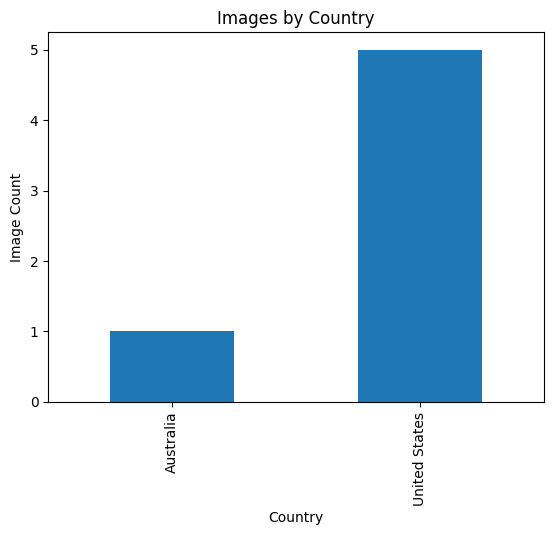

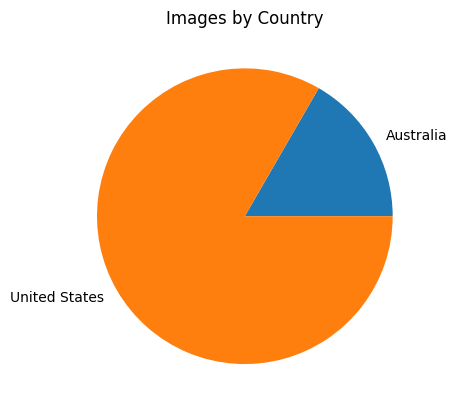

In [15]:
geolocator = Nominatim(user_agent="geoapiExercises")

# Get the continent information for each coordinate
for key, coord in coordinates.items():
    if len(coord) < 3:
        location = geolocator.reverse(coord, exactly_one=True)
        address = location.raw['address']
        country = address.get('country', '')
        coordinates[key].append(country)

# Create a pandas DataFrame from the coordinates dictionary
df = pd.DataFrame.from_dict(coordinates, orient='index', columns=['Latitude', 'Longitude', 'Country'])

# Group the DataFrame by continent and count the number of images
country_count = df.groupby('Country')['Country'].count()

# Create a bar graph showing the number of images on each continent
fig, ax = plt.subplots()
country_count.plot(kind='bar', ax=ax)
ax.set_title('Images by Country')
ax.set_xlabel('Country')
ax.set_ylabel('Image Count')
plt.show()

# Create a pie chart showing the number of images on each continent
fig2, ax = plt.subplots()
country_count.plot(kind='pie', ax=ax)
ax.set_title('Images by Country')
ax.set_ylabel('')
plt.show()


# Graph images : by Dominant Color

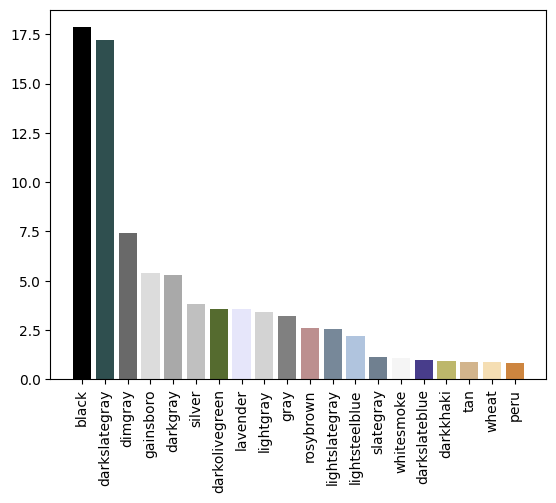

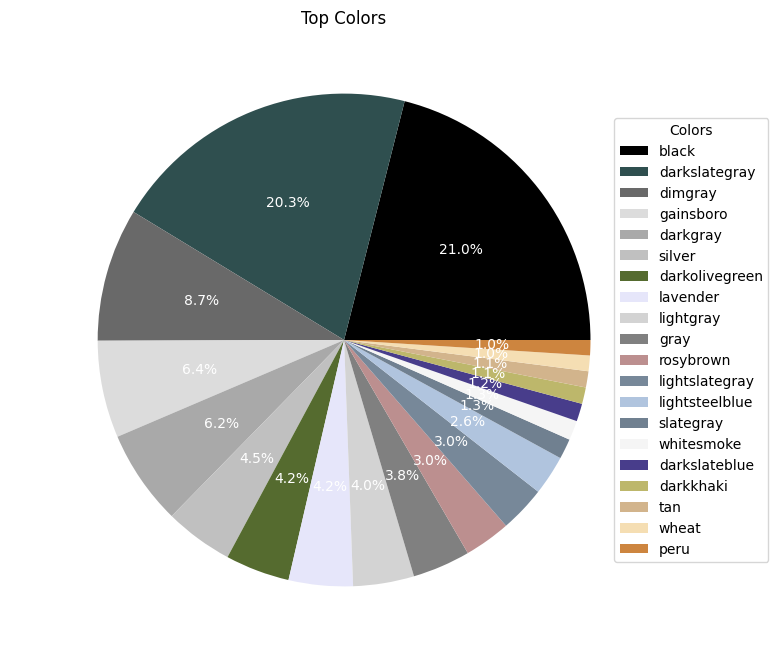

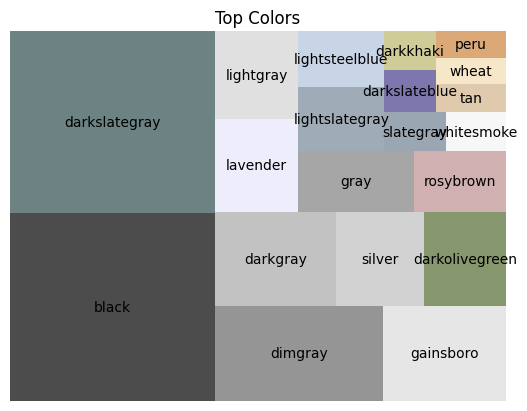

In [16]:
MAX_COLUMNS = 20

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

dict_dom_color = {}
for idx, dom_color in enumerate(dict_metadata['dominant_color']):
    if dom_color is not None:
        list_dom_color = eval(dom_color)
        dict_dom_color.update({dict_metadata['file'][idx] : list_dom_color})

color_counts = Counter()
for image_colors in dict_dom_color.values():
    for color, percentage in image_colors:
        color_counts[color] += percentage

# Map hexadecimal codes to color names
color_names = {}
for code in color_counts.keys():
    try:
        rgb = webcolors.hex_to_rgb(code)
        actual, closest = get_colour_name(rgb)
        color_names[code] = closest
    except ValueError:
        pass

dict_res = {}
for key, val in color_names.items():
    if val in dict_res:
        dict_res[val] += round(color_counts[key]/100, 5)
    else:
        dict_res[val] = round(color_counts[key]/100, 5)

if sum(dict_res.values()) > 100:
    raise Exception('sum of dict_res.values() > 100')

columns = dict_res.__len__()
if columns > MAX_COLUMNS:
    columns = MAX_COLUMNS

sorted_colors = sorted(dict_res.items(), key=lambda x: x[1], reverse=True)
top_colors = dict(sorted_colors[:columns])

# Create a bar graph showing the dominant colors in the images
plt.bar(top_colors.keys(), top_colors.values(), color=top_colors.keys())
plt.xticks(rotation=90)
plt.show()

# Create a pie chart showing the dominant colors in the images
fig, ax = plt.subplots(figsize=(8, 8))
colors = list(top_colors.keys())
ax.pie(top_colors.values(), labels=top_colors.keys(), autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})
ax.set_title('Top Colors')
ax.legend(title='Colors', loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.show()

# Create a treemap showing the dominant colors in the images
color = [webcolors.name_to_hex(c) for c in top_colors]
labels = list(top_colors.keys())
sizes = list(top_colors.values())
squarify.plot(sizes=sizes, label=labels, color=color, alpha=.7)
plt.title("Top Colors")
plt.axis('off')
plt.show()

# Graph images : by Tags

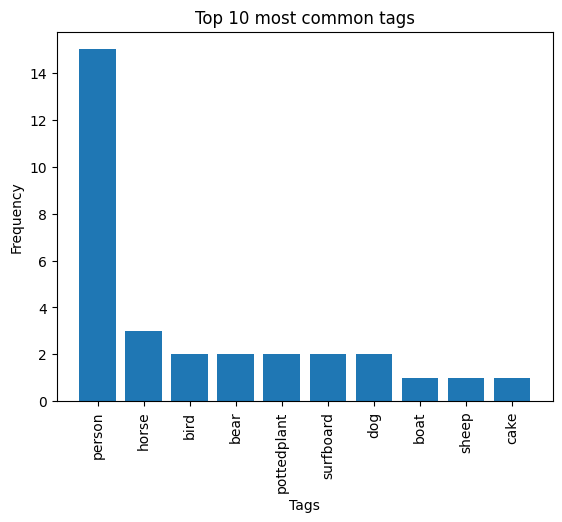

In [17]:
# convert tag strings to a list of tags
tags = list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']]))

# count the occurrences of each tag
tag_counts = Counter(tags)

# plot the most common tags
n = 10
top_tags = dict(tag_counts.most_common(n))
plt.bar(top_tags.keys(), top_tags.values())
plt.title(f"Top {n} most common tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


In [18]:
tags = set(list(itertools.chain.from_iterable([ast.literal_eval(t) for t in dict_metadata['tags']])))

try:
    nlp = spacy.load("en_core_web_lg")  # load pre-trained word embedding model
except OSError:
    !python -m spacy download en_core_web_lg

categories = {
    "landscape" : {}, "animal" : {}, "people" : {}, "food" : {}, "building" : {}, "vehicle" : {}, "object" : {}, "other" : {}
}

# categorize words based on similarity to category prototypes
for word in tags:
    # find the most similar category prototype for the word
    max_similarity = -1
    chosen_category = "other"
    for category in categories:
        similarity = nlp(word).similarity(nlp(category))
        if similarity > max_similarity:
            max_similarity = similarity
            chosen_category = category

    # add the word into the appropriate category dictionary
    categories[chosen_category].update({word : max_similarity})

print(categories)

C:\Users\woloz\AppData\Local\Temp\ipykernel_14860\1672375328.py:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = nlp(word).similarity(nlp(category))


{'landscape': {'pottedplant': 0.0}, 'animal': {'cow': 0.4426231622351475, 'cat': 0.5024607370782399, 'bird': 0.5178147465813449, 'giraffe': 0.4304788287266817, 'horse': 0.4154476921938662, 'bear': 0.36976549745997483, 'dog': 0.5192115548746556, 'sheep': 0.4976083530809249}, 'people': {'person': 0.6675476314097037}, 'food': {'cake': 0.2982754078174335, 'cup': 0.13201074075792676}, 'building': {}, 'vehicle': {'boat': 0.4772506904585992, 'surfboard': 0.4291811270731309, 'car': 0.7779995600787694, 'backpack': 0.37419563932857847}, 'object': {}, 'other': {}}


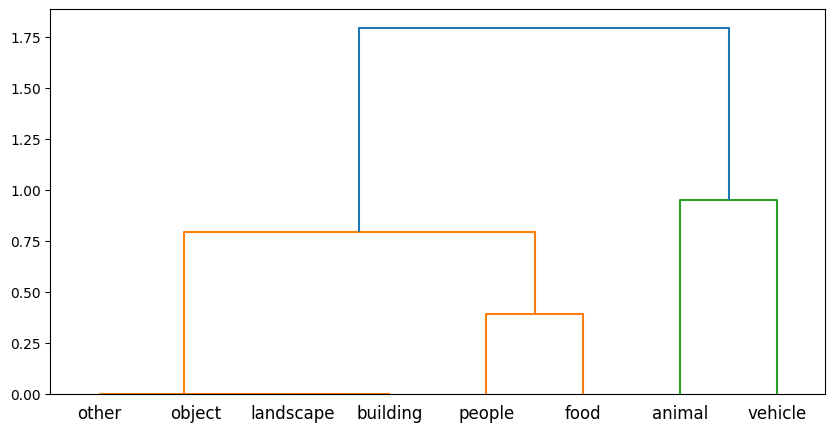

In [19]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Convert the dictionary into a numpy array
def dict_to_array(categories):
    arr = np.zeros((len(categories), len(categories)))
    for i, (cat, subcat) in enumerate(categories.items()):
        for j, (subcat, val) in enumerate(subcat.items()):
            arr[i,j] = val
    return arr

# Generate the linkage matrix
Z = linkage(dict_to_array(categories), 'ward')

# Plot the dendrogram
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels=list(categories.keys()))
plt.show()

In [20]:
# Create a label for the title
title_label = widgets.Label(value='User Information Form',
                            layout=widgets.Layout(width='100%', height='auto',
                                                  justify_content='center',
                                                  align_items='center'))

# Create text boxes for first and last name
pseudo = widgets.Text(description='Pseudo :')

# Create a color picker for favorite colors
color_picker = widgets.ColorPicker(
    concise=True,
    description='Favorite Colors:',
    value='#FF0000',
    continuous_update=False,
    disabled=False
)

# Create a dropdown for image orientation
orientation_dropdown = widgets.Dropdown(
    options=['Portrait', 'Landscape'],
    value='Portrait',
    description='Orientation:'
)

# Create sliders for image height and width
height_slider = widgets.IntSlider(min=100, max=4000, step=100, description='Height:')
width_slider = widgets.IntSlider(min=100, max=4000, step=100, description='Width:')

#  Create a button to submit the form
submit_button = widgets.Button(description='Submit')

# Create a VBox container for the widgets
form_container = widgets.VBox([
    title_label,
    pseudo,
    color_picker,
    orientation_dropdown,
    height_slider,
    width_slider,
    submit_button
])

# Define a function to handle form submission
def on_submit_button_clicked(b):
    # Get the form data
    pseudo_value = pseudo.value
    color_picker_value = color_picker.value
    orientation_value = orientation_dropdown.value
    height_value = height_slider.value
    width_value = width_slider.value

    # Print the form data
    print('pseudo:', pseudo_value)
    print('Favorite Colors:', color_picker_value)
    print('Orientation:', orientation_value)
    print('Height:', height_value)
    print('Width:', width_value)

# Attach the on_submit_button_clicked function to the button click event
clicked = submit_button.on_click(on_submit_button_clicked)

# Display the form container
display(form_container)
